In [27]:
h = 1e-5

f = lambda x:x*x

df = lambda x: (f(x+h)-f(x))/h

df(3)

6.000009999951316

In [28]:
3+2

5

In [69]:
from typing import Union
from graphviz import Digraph
import math
class Value:

    # Inititalisation
    def __init__(self,val:Union[int,float],_children=(),label="",_op=""):
        self.val:Union[int,float]=val
        self.grad:float=0
        self._children=_children
        self.label=label
        self._op=_op
        self._backward=None

    def __repr__(self) -> str:
         return f"{self.label} || Value :  {self.val} | Grad : {self.grad}"
    
    # Addition
    def __add__(self,other:Union[int,float,'Value'])->'Value':
        if isinstance(other,(float,int)):
            other=Value(other)
        out = Value(self.val+other.val,_children=(self,other),_op="+")
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 *out.grad
        out._backward = _backward
        return out
        
    # Substration
    def __sub__(self,other:Union[int,float,'Value'])->'Value':
        if isinstance(other,(float,int)):
            other = Value(other)
        out = Value(self.val-other.val,_children=(self,other),_op="-")
        def _backward():
            self.grad += 1 * out.grad
            other.grad -= 1 * out.grad
        out._backward = _backward
        return out

    # Multiplication
    def __mul__(self,other:Union[int,float,'Value'])->'Value':
        if isinstance(other,(float,int)):
            other=Value(other)
        out = Value(self.val*other.val,_children=(self,other),_op="*")
        def _backward():
            self.grad += other.val*out.grad
            other.grad += other.val*out.grad
        out._backward = _backward
        return out

    # Division
    def __truediv__(self,other:Union[int,float,'Value'])->'Value':
        if isinstance(other,(float,int)):
            other = Value(other)
        out = Value(self.val/other.val,_children=(self,other),_op="/")
        def _backward():
            self.grad += (1/other.val)/out.grad
            other.grad += self.val*math.log(out.grad)
        out._backward = _backward
        return out
        
    def __radd__(self,other:Union[int,float,'Value'])->'Value':
        return self+other
    
    def __rmul__(self,other:Union[int,float,'Value'])->'Value':
        return self*other

    def __rsub__(self,other:Union[int,float,'Value'])->'Value':
        return self-other
    
    # Power
    def __pow__(self,other:Union[int,float])->'Value':
        assert isinstance(other,(int,float)),"Error , power fn only supports integers and floats"
        out = Value(self.val**other,_children=(self,),_op="**")
        def _backward():
            self.grad += other*(self.val**(other-1))*out.grad
        out._backward = _backward
        return out
    
    # Get the main node that are needed to be visited to set backward() call we do Topological Sort
    def _topo_sort(self):
        visited = set()
        stack = []
        def visit(node):
            if node not in visited:
                visited.add(node)
                for child in node._children:
                    visit(child)
                stack.append(node)
        visit(self)
        return reversed(stack)

    # automate backward() call fr all node when an value is changed in grad
    def backward(self):
        self.grad = 1
        for node in self._topo_sort():
            node._backward()
    
    def _get_edges_nodes(self):
        edges=set()
        nodes=set()
        def dfs(node):
            if node not in nodes:
                for child in  node._children:
                    edges.add((child,node))
                    dfs(child)
                nodes.add(node)
        dfs(self)
        return nodes,edges

    def graph(self):
        graph=Digraph(format="svg",graph_attr={'rankdir':'LR'})
        nodes,edges=self._get_edges_nodes()
        for node in nodes:
            node_id=str(id(node))
            graph.node(name=node_id,label=f"{node.label} | value = {node.val} | grad = {node.grad}",shape="box")
            if node._op:
                op_id = node_id + node._op
                graph.node(name=op_id,label=node._op, shape="circle")
                graph.edge(op_id,node_id)

        for node1,node2 in edges:
            n1_id = str(id(node1))
            n2_id = str(id(node2)) + node2._op
            graph.edge(n1_id,n2_id)
        return graph
        

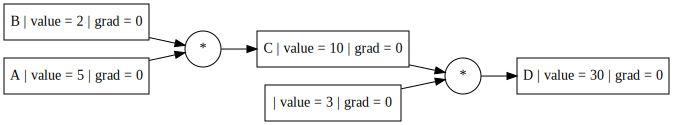

In [30]:
a=Value(5,label='A')
b=Value(2,label='B')
c=a*b;c.label='C';
d=c*Value(3); d.label='D';
d.graph()

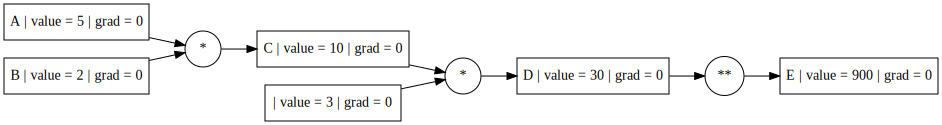

In [31]:
a=Value(5,label='A')
b=Value(2,label='B')
c=a*b;c.label='C';
d=c*Value(3); d.label='D';
e=d**2; e.label='E'
e.graph()

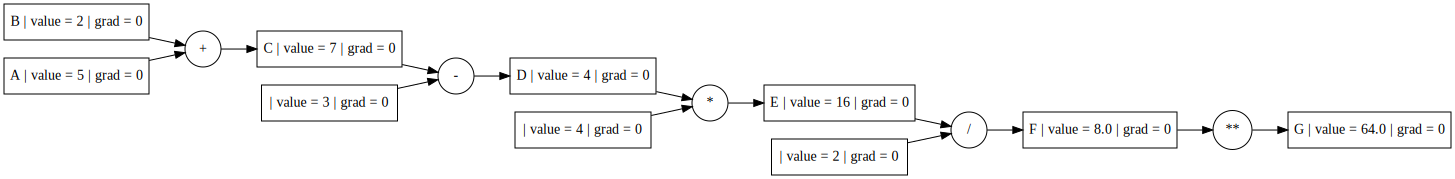

In [35]:
a = Value(5,label='A')
b = Value(2,label='B')
c = a+b; c.label='C';
d = c-Value(3); d.label='D';
e = d*Value(4); e.label='E';
f = e/Value(2); f.label='F';
g = f**2; g.label='G'
g.graph()

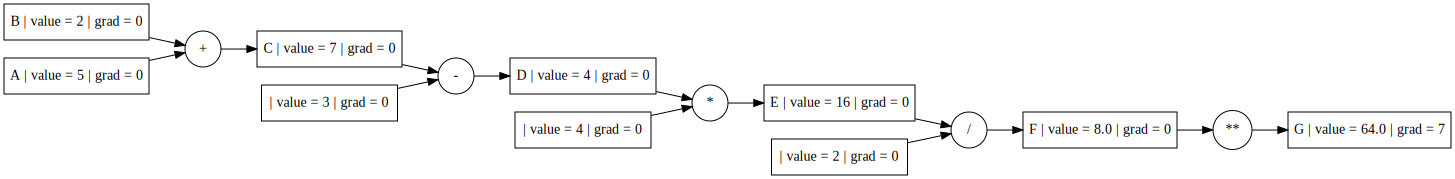

In [56]:
g.grad = 7
g.graph()

In [62]:
import numpy as np
x = np.random.rand()
x

0.763341364070796

In [63]:
g.backward()

AttributeError: 'Value' object has no attribute 'backward'

In [64]:
g._backward()


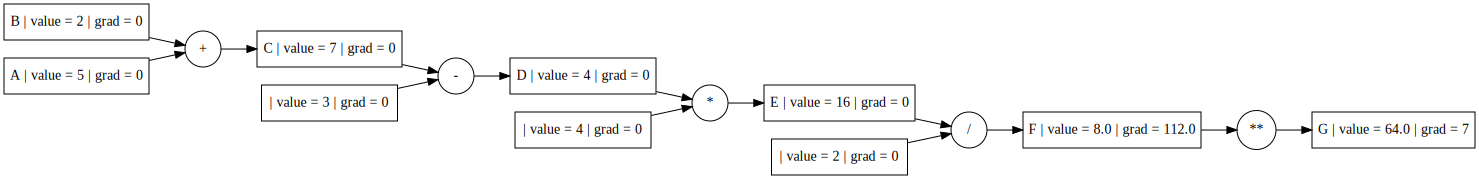

In [65]:
g.graph()

In [68]:
f.backward()

AttributeError: 'Value' object has no attribute 'backward'